# Proyecto Final

***Equipo 07***

- Aide Jazmín González Cruz
- Elena Villalobos Nolasco
- Carolina Acosta Tovany

#### Instrucciones

El proyecto/examen final consistirá en:

La implementación del algoritmo de filtrado colaborativo utilizando la metodología vista en clase (uso de otra metodología no se calificará).

Todos los algoritmos de aprendizaje de máquina que se utilicen deberán haber sido creados por ustedes. Sólo podrán utilizar Transformers y funciones de apoyo de scikit-learn (para realizar la división de los datos en entrenamiento y prueba, o el procedimiento de validación cruzada, etc.) mas ningún estimator (regresión logística, máquina de vectores de soporte, k medias, etc.). 

Se deberá explicar como se obtuvo la k con la que se generó el resultado final.

Se utilizarán los archivos con el conjunto pequeño de calificaciones y películas ubicado en la siguiente https://www.kaggle.com/rounakbanik/the-movies-dataset:

- **links_small.csv**: Contains the TMDB and IMDB IDs of a small subset of 9,000 movies of the Full Dataset.

- **ratings_small.csv**: The subset of 100,000 ratings from 700 users on 9,000 movies.

Con el fin de mejorar la calificación (opcional, puntos extra), se podrán utilizar los algoritmos desarrollado en las tareas del curso y los datos relevantes (los que hacen match con los datos anteriores) contenidos en los archivos:

- **movies_metadata.csv**: The main Movies Metadata file. Contains information on 45,000 movies featured in the Full MovieLens dataset. Features include posters, backdrops, budget, revenue, release dates, languages, production countries and companies.

- **keywords.csv**: Contains the movie plot keywords for our MovieLens movies. Available in the form of a stringified JSON Object.

- **credits.csv**: Consists of Cast and Crew Information for all our movies. Available in the form of a stringified JSON Object.

La métrica con la que se determinará el desempeño del algoritmo es el NDCG 

(https://en.wikipedia.org/wiki/Discounted_cumulative_gain#Normalized_DCG)

Una vez obtenida la matriz de calificaciones, el programa deberá ser capaz de regresar las 5 mejores recomendaciones del o de los usuarios que se consulten.

El proyecto se entregará en un Jupyter notebook. El readme file debe contener las instrucciones para que se ejecute el código. Deben cerciorarse que siguiendo esas instrucciones el programa corre sin errores. 

Se deberá subir a la carpeta proyecto_final/equipo_xx en el repositorio GitHub antes de las 7:00 am del día del examen final (14 de diciembre de 2020).    

In [2]:
# Importación de paqueterías necesarias
import pandas as pd
import numpy as np
import random

La función objetivo:
    
$$J(X) = \frac{1}{2} \displaystyle\sum_{(a,i)\in\mathbb{D}} \left(Y_{ai}-\left [ UV^T \right ]_{ai} \right)^2 + \frac{\lambda}{2} \displaystyle\sum_{a=1}^n \displaystyle\sum_{j=1}^k U_{aj}^2 + \frac{\lambda}{2} \displaystyle\sum_{i=1}^m \displaystyle\sum_{j=1}^k V_{ij}^2$$

In [3]:
def load_data():
    """
    Carga datos
    Regresa dataframe de Usuarios, Películas y raitings
    """
    
    # Carga de datos
    links_small = pd.read_csv('links_small.csv')
    ratings_small = pd.read_csv('ratings_small.csv')
    
    # Películas en catálogo que no han calificado los usuarios
    df_mov_u = pd.DataFrame(ratings_small['movieId'])
    df_mov = pd.DataFrame(links_small['movieId'])

    common = df_mov.merge(df_mov_u, on=["movieId"])
    result = df_mov[~df_mov.movieId.isin(common.movieId)]
    
    # Construyendo la matriz Y_ai
    y_ia = links_small.set_index('movieId').join(ratings_small.set_index('movieId'))
    y_ia = y_ia.reset_index()
    #y_ia.pivot(index="userId", columns="movieId", values="rating") 
    y_ia = pd.DataFrame(y_ia.pivot(index='userId', columns='movieId', values='rating'))
    y_ia = pd.DataFrame(y_ia.to_records())
    # Eliminando usuario Nan
    y_ia = y_ia[pd.notnull(y_ia['userId'])]
    # Borrando columna 1 con user_id
    y_ia = y_ia.drop(['userId'], axis=1)
    # Cambiando Nan por zeros
    #y_ia[np.isnan(y_ia)] = 0
    
    return y_ia
    

In [4]:
Y = load_data()
Y

,1,2,3,4,5,6,7,8,9,10,...,161830,161918,161944,162376,162542,162672,163056,163949,164977,164979
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
668,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
669,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
670,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
maxValues = Y.max() 
maxValues = pd.DataFrame(maxValues)
maxValues = maxValues.max() 
maxValues

0    5.0
dtype: float64

In [6]:
minValues = Y.min() 
minValues = pd.DataFrame(minValues)
minValues = minValues.min() 
minValues

0    0.5
dtype: float64

In [7]:
# Cambiando Nan por zeros
Y_0 = Y.copy()
Y_0[np.isnan(Y_0)] = 0
Y_0

,1,2,3,4,5,6,7,8,9,10,...,161830,161918,161944,162376,162542,162672,163056,163949,164977,164979
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
668,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
669,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
670,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
import numpy as np
import pandas as pd
np.random.seed(0)

In [9]:
n_users, n_items = Y_0.shape
print(n_users, n_items)

671 9125


In [10]:
# Create r_{ui}, our ratings matrix
ratings = Y_0
ratings

,1,2,3,4,5,6,7,8,9,10,...,161830,161918,161944,162376,162542,162672,163056,163949,164977,164979
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
668,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
669,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
670,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
ratings.shape[0]

671

### https://www.ethanrosenthal.com/2016/01/09/explicit-matrix-factorization-sgd-als/

In [13]:
# Split into training and test sets. 
# Remove 10 ratings for each user 
# and assign them to the test set
def train_test_split(ratings):
    """
    split into training and test sets,
    remove 10 ratings from each user
    and assign them to the test set
    """
    test = np.zeros(ratings.shape)
    train = ratings.copy()
    for user in range(ratings.shape[0]):
        test_index = np.random.choice(
            np.flatnonzero(ratings[user]), size = 10, replace = False)

        train[user, test_index] = 0.0
        test[user, test_index] = ratings[user, test_index]
        
    # assert that training and testing set are truly disjoint
    assert np.all(train * test == 0)
    return train, test

train, test = train_test_split(np.array(ratings))
train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [5., 0., 0., ..., 0., 0., 0.]])

In [14]:
def mse_f(actual, predicted):
    sum_error = 0.0
    # loop over all values
    for i in range(len(actual)):
        # the error is the sum of (actual - prediction)^2
        prediction_error =  actual[i] - predicted[i]
        sum_error += (prediction_error ** 2)
    # now normalize
    mean_error = sum_error / float(len(actual))
    return (mean_error)

def get_mse(pred, actual):
    # Ignore nonzero terms.
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return mse_f(pred, actual)

In [27]:
from numpy.linalg import solve
#from past.builtins import xrange

In [25]:
class ExplicitMF():
    def __init__(self, 
                 ratings, 
                 n_factors=40, 
                 item_reg=0.0, 
                 user_reg=0.0,
                 verbose=False):
        """
        Train a matrix factorization model to predict empty 
        entries in a matrix. The terminology assumes a 
        ratings matrix which is ~ user x item
        
        Params
        ======
        ratings : (ndarray)
            User x Item matrix with corresponding ratings
        
        n_factors : (int)
            Number of latent factors to use in matrix 
            factorization model
        
        item_reg : (float)
            Regularization term for item latent factors
        
        user_reg : (float)
            Regularization term for user latent factors
        
        verbose : (bool)
            Whether or not to printout training progress
        """
        
        self.ratings = ratings
        self.n_users, self.n_items = ratings.shape
        self.n_factors = n_factors
        self.item_reg = item_reg
        self.user_reg = user_reg
        self._v = verbose

    def als_step(self,
                 latent_vectors,
                 fixed_vecs,
                 ratings,
                 _lambda,
                 type='user'):
        """
        One of the two ALS steps. Solve for the latent vectors
        specified by type.
        """
        if type == 'user':
            # Precompute
            YTY = fixed_vecs.T.dot(fixed_vecs)
            lambdaI = np.eye(YTY.shape[0]) * _lambda
            
            #Reemplazando xrange por range
            #"""
            for u in range(latent_vectors.shape[0]):
                latent_vectors[u, :] = solve((YTY + lambdaI), 
                                             ratings[u, :].dot(fixed_vecs))
            """
            for u in range(latent_vectors.shape[0]):
                latent_vectors[u] = solve((YTY + lambdaI), 
                                             ratings[u].dot(fixed_vecs))
            """    
                
        elif type == 'item':
            # Precompute
            XTX = fixed_vecs.T.dot(fixed_vecs)
            lambdaI = np.eye(XTX.shape[0]) * _lambda
            
            #Reemplazando xrange por range
            
            for i in range(latent_vectors.shape[0]):
                latent_vectors[i, :] = solve((XTX + lambdaI), 
                                             ratings[:, i].T.dot(fixed_vecs))
            """
            for i in range(latent_vectors.shape[0]):
                latent_vectors[i] = solve((XTX + lambdaI), 
                                             ratings[i].T.dot(fixed_vecs))
            """
        return latent_vectors

    def train(self, n_iter=10):
        """ Train model for n_iter iterations from scratch."""
        # initialize latent vectors
        self.user_vecs = np.random.random((self.n_users, self.n_factors))
        self.item_vecs = np.random.random((self.n_items, self.n_factors))
        
        self.partial_train(n_iter)
    
    def partial_train(self, n_iter):
        """ 
        Train model for n_iter iterations. Can be 
        called multiple times for further training.
        """
        ctr = 1
        while ctr <= n_iter:
            if ctr % 10 == 0 and self._v:
                print('\tcurrent iteration: {}'.format(ctr))
            self.user_vecs = self.als_step(self.user_vecs, 
                                           self.item_vecs, 
                                           self.ratings, 
                                           self.user_reg, 
                                           type='user')
            self.item_vecs = self.als_step(self.item_vecs, 
                                           self.user_vecs, 
                                           self.ratings, 
                                           self.item_reg, 
                                           type='item')
            ctr += 1
    
    def predict_all(self):
        """ Predict ratings for every user and item. """
        predictions = np.zeros((self.user_vecs.shape[0], 
                                self.item_vecs.shape[0]))
        # cambiando xrange por range
        for u in range(self.user_vecs.shape[0]):
            for i in range(self.item_vecs.shape[0]):
                predictions[u, i] = self.predict(u, i)
                
        return predictions
    def predict(self, u, i):
        """ Single user and item prediction. """
        return self.user_vecs[u, :].dot(self.item_vecs[i, :].T)
    
    def calculate_learning_curve(self, iter_array, test):
        """
        Keep track of MSE as a function of training iterations.
        
        Params
        ======
        iter_array : (list)
            List of numbers of iterations to train for each step of 
            the learning curve. e.g. [1, 5, 10, 20]
        test : (2D ndarray)
            Testing dataset (assumed to be user x item).
        
        The function creates two new class attributes:
        
        train_mse : (list)
            Training data MSE values for each value of iter_array
        test_mse : (list)
            Test data MSE values for each value of iter_array
        """
        iter_array.sort()
        self.train_mse =[]
        self.test_mse = []
        iter_diff = 0
        for (i, n_iter) in enumerate(iter_array):
            if self._v:
                print('Iteration: {}'.format(n_iter))
            if i == 0:
                self.train(n_iter - iter_diff)
            else:
                self.partial_train(n_iter - iter_diff)

            predictions = self.predict_all()

            self.train_mse += [get_mse(predictions, self.ratings)]
            self.test_mse += [get_mse(predictions, test)]
            if self._v:
                print('Train mse: ' + str(self.train_mse[-1]))
                print('Test mse: ' + str(self.test_mse[-1]))
            iter_diff = n_iter

# Observaciones, tarda mucho en correr la siguiente parte

In [26]:
MF_ALS = ExplicitMF(train, n_factors=40, \
                    user_reg=0.0, item_reg=0.0)
iter_array = [1, 2, 5, 10, 25, 50, 100]
MF_ALS.calculate_learning_curve(iter_array, test)

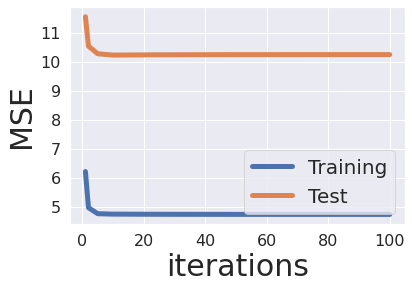

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

def plot_learning_curve(iter_array, model):
    plt.plot(iter_array, model.train_mse, \
             label='Training', linewidth=5)
    plt.plot(iter_array, model.test_mse, \
             label='Test', linewidth=5)


    plt.xticks(fontsize=16);
    plt.yticks(fontsize=16);
    plt.xlabel('iterations', fontsize=30);
    plt.ylabel('MSE', fontsize=30);
    plt.legend(loc='best', fontsize=20);
    
plot_learning_curve(iter_array, MF_ALS)

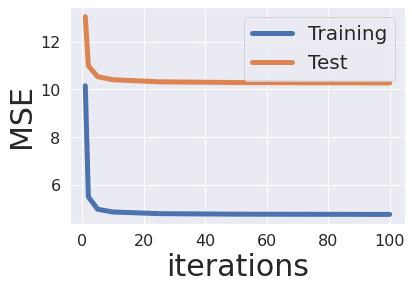

In [29]:
MF_ALS = ExplicitMF(train, n_factors=40, \
                    user_reg=1., item_reg=1.)

iter_array = [1, 2, 5, 10, 25, 50, 100]
MF_ALS.calculate_learning_curve(iter_array, test)
plot_learning_curve(iter_array, MF_ALS)

In [32]:
latent_factors = [5, 10, 20, 40, 80]
regularizations = [0.01, 0.1, 1., 10., 100.]
regularizations.sort()
iter_array = [1, 2, 5, 10, 25, 50, 100]

best_params = {}
best_params['n_factors'] = latent_factors[0]
best_params['reg'] = regularizations[0]
best_params['n_iter'] = 0
best_params['train_mse'] = np.inf
best_params['test_mse'] = np.inf
best_params['model'] = None

for fact in latent_factors:
    print('Factors: {}'.format(fact))
    for reg in regularizations:
        print('Regularization: {}'.format(reg))
        MF_ALS = ExplicitMF(train, n_factors=fact, \
                            user_reg=reg, item_reg=reg)
        MF_ALS.calculate_learning_curve(iter_array, test)
        min_idx = np.argmin(MF_ALS.test_mse)
        if MF_ALS.test_mse[min_idx] < best_params['test_mse']:
            best_params['n_factors'] = fact
            best_params['reg'] = reg
            best_params['n_iter'] = iter_array[min_idx]
            best_params['train_mse'] = MF_ALS.train_mse[min_idx]
            best_params['test_mse'] = MF_ALS.test_mse[min_idx]
            best_params['model'] = MF_ALS
            print('New optimal hyperparameters')
            print(pd.Series(best_params))

Factors: 5
Regularization: 0.01
New optimal hyperparameters
n_factors                                                 5
reg                                                    0.01
n_iter                                                   25
train_mse                                           7.75551
test_mse                                            11.1283
model        <__main__.ExplicitMF object at 0x7fa702de4750>
dtype: object
Regularization: 0.1
Regularization: 1.0
Regularization: 10.0
Regularization: 100.0
Factors: 10
Regularization: 0.01
New optimal hyperparameters
n_factors                                                10
reg                                                    0.01
n_iter                                                  100
train_mse                                           6.86762
test_mse                                            10.6889
model        <__main__.ExplicitMF object at 0x7fa702de47d0>
dtype: object
Regularization: 0.1
Regularization: 1.0
Regulari

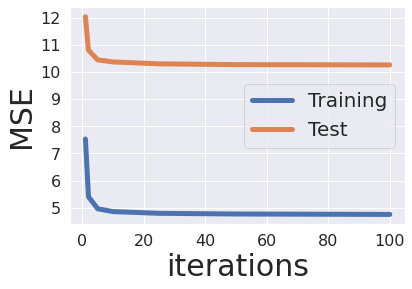

In [33]:
best_als_model = best_params['model']
plot_learning_curve(iter_array, best_als_model)